In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 

currentPath = os.getcwd()
os.chdir('/Users/kimfr/OneDrive - unist.ac.kr/Optimization')

In [2]:
GSPC = pd.read_csv('^GSPC.csv')
TNX = pd.read_csv('^TNX.csv')

In [3]:
GSPC_logret = np.log(GSPC['Adj Close']/GSPC['Adj Close'].shift(1))
GSPC_logret

0           NaN
1      0.010502
2     -0.006337
3      0.005585
4      0.006240
         ...   
247    0.004064
248    0.005566
249   -0.000833
250    0.003248
251   -0.003027
Name: Adj Close, Length: 252, dtype: float64

In [4]:
df_logret = pd.DataFrame({'stock' : GSPC_logret, 'bond' : TNX['Adj Close']/100/251})
df_logret.loc[0,('stock','bond')] = 0.0
df_logret

,stock,bond
0,0.000000,0.000000
1,0.010502,0.000128
2,-0.006337,0.000128
3,0.005585,0.000128
4,0.006240,0.000128
...,...,...
247,0.004064,0.000074
248,0.005566,0.000073
249,-0.000833,0.000072
250,0.003248,0.000067


In [5]:
mu= df_logret.mean() * 252
mu = mu.values.T
sigma = df_logret.cov()*252
sigma = sigma.values
print(mu)
print(sigma)

[0.11346409 0.02316323]
[[ 2.46375503e-02 -5.31339269e-07]
 [-5.31339269e-07  1.00292976e-07]]


In [16]:
num_samples = 5000
bond, stock = np.random.multivariate_normal(mu,sigma,num_samples).T

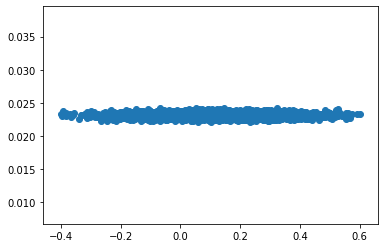

In [17]:
plt.scatter(bond,stock)

In [18]:
from sklearn.cluster import KMeans

num_clusters = 10
kmeans = KMeans(n_clusters = num_clusters).fit(np.transpose([bond,stock]))

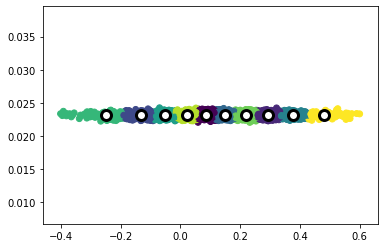

In [19]:
plt.scatter(bond, stock, c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=100, 
           color = 'white', edgecolor ='black', linewidth=3)

In [24]:
print("Scenario probabilities\n")
p=np.zeros(num_clusters)
for i in range(num_clusters):
    p[i] = np.count_nonzero(kmeans.labels_== i)/num_samples
    print("cluster " +str(i)+": {:6.2%}".format(p[i],1))

Scenario probabilities

cluster 0: 15.82%
cluster 1: 10.98%
cluster 2:  7.08%
cluster 3: 15.38%
cluster 4:  5.66%
cluster 5: 10.94%
cluster 6:  2.76%
cluster 7: 14.16%
cluster 8: 15.06%
cluster 9:  2.16%


In [26]:
scenarios = 1 + kmeans.cluster_centers_
scenarios

array([[1.08616163, 1.02316252],
       [1.29222017, 1.02317465],
       [0.86881376, 1.0231718 ],
       [1.15031797, 1.02314983],
       [1.37627266, 1.02318316],
       [0.94960571, 1.02316941],
       [0.75063527, 1.02314826],
       [1.21896972, 1.023163  ],
       [1.02071676, 1.02318338],
       [1.48214045, 1.02316295]])

In [28]:
import cvxpy as cp

x_0 = cp.Variable(2)
y = cp.Variable(num_clusters)
w = cp.Variable(num_clusters)
q=1 ;r=4
initial_amount = 100
goal_amount = 104

In [32]:
goal= cp.Maximize(p.T * (q*y - r*w))
prob= cp.Problem(goal,[sum(x_0) == initial_amount, scenarios * x_0 - y + w 
                      ==goal_amount * np.ones(num_clusters),x_0>=0, y>=0, w>=0])

In [33]:
prob.solve(solver = cp.ECOS)

-2.5709747428815466

In [34]:
print("optimal allocation: " +  "{:2.2f}".format(x_0.value[0]) + ", " 
     + "{:2.2f}".format(x_0.value[1]))
print("expected return: "+"{:.2%}".format((goal_amount + np.dot(p, y.value-w.value))/initial_amount-1,1))

optimal allocation: 100.00, 0.00
expected return: 11.30%


Text(0, 0.5, 'final wealth')

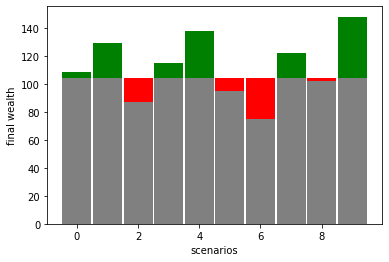

In [38]:
fig, ax = plt.subplots(1,1)
ax.bar(range(num_clusters), np.round(goal_amount+y.value,2),color='green',width=0.95)
ax.bar(range(num_clusters), goal_amount, color='red', width =0.95)
ax.bar(range(num_clusters), np.round(goal_amount-w.value,2),color ='grey',width =0.95)
ax.set_xlabel('scenarios')
ax.set_ylabel('final wealth')